# **Chapter 13 (TensorFlow Recipes)**
## *Deep Learning for Time Series Forecasting*, 

This chapter covers more advanced deep learning architectures using TensorFlow/Keras and PyTorch. The chapter starts with a high-level API (Keras) and then dives into more complex implementations, using a lower-level API (PyTorch).


In this chapter, you will see the following recipes:
* Forecasting with an RNN using Keras
* Forecasting with LSTM using Keras
* Forecasting with a GRU using Keras

# Technical Requirements

It is recommended that you create two separate virtual Python environments – one for TensorFlow/Keras and one for PyTorch. You can install all the required dependencies and their specific versions without causing conflicts in other environments. If you prefer, you can still try and install them together in a new virtual environment. If you need a quick refresher on creating a virtual Python environment, check out the *Development environment setup* recipe from **Chapter 1**, *Getting Started with Time Series Analysis*. The chapter covers two methods – using `conda` and `venv`.

The following instructions will create two virtual environments using `conda`. You can call the environments any name you like.

### Installing TensorFlow

The following example will name the environment TensorFlow:
```
conda create -n tensorflow python=3.9 -y
conda activate tensorflow
pip install tensorflow
```

For the latest instructions or troubleshooting, please visit the main page here: https://www.tensorflow.org/install.

To make the new tensorflow environment visible within Jupyter, you can run the following code:
```
python -m ipykernel install --user --name tensorflow --displayname "tensorflow"
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
tensorflow -> 2.9.1



In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 7]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

# Preparing Time Series Data for Deep Learning

In [4]:
path = Path('../../datasets/Ch13/')

In [5]:
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [6]:
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [7]:
print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


### Visualize the time series data

<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

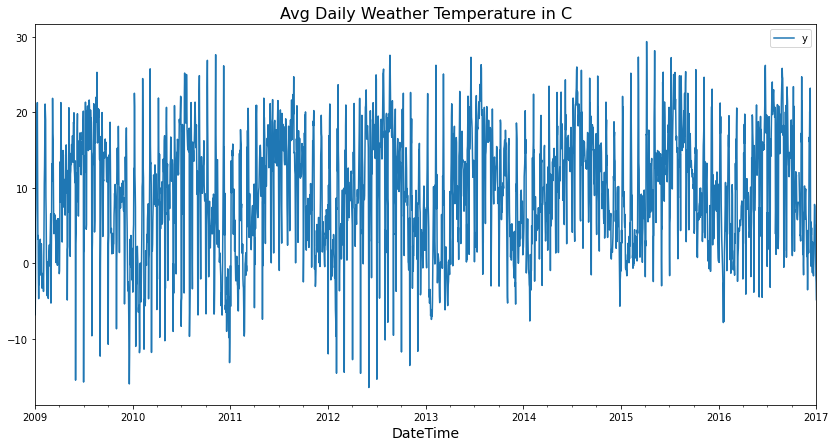

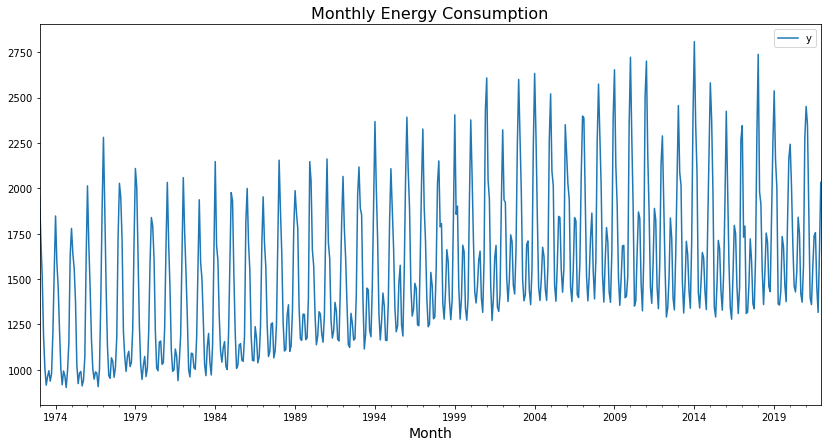

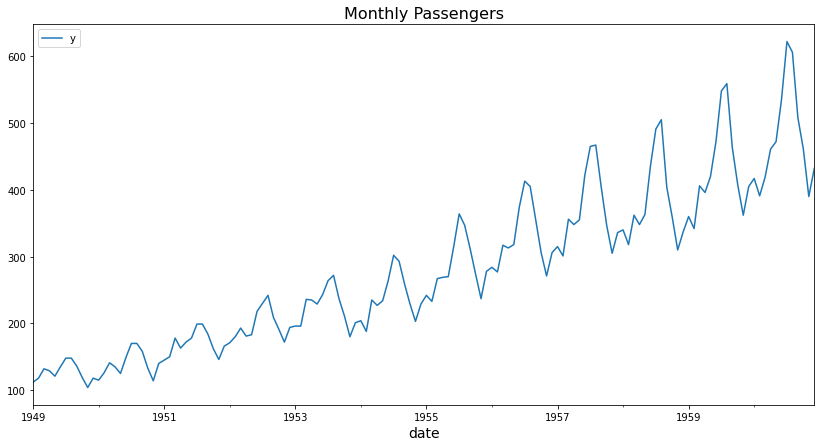

In [8]:
daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

## Tranform the data sets
### Windowing

In [9]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

In [10]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [11]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [12]:
air_df = one_step_forecast(air_cp, 10)
en_df = one_step_forecast(en_cp, 10)
dw_df = one_step_forecast(dw_cp, 10)
print(air_df.shape)
print(en_df.shape)
print(dw_df.shape)

(134, 11)
(578, 11)
(2913, 11)


### Scale and split data

In [13]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [14]:
scale_air = Standardize(air_df)
scale_dw = Standardize(dw_df)
scale_en = Standardize(en_df)

train_air, test_air, val_air = scale_air.fit_transform()
train_dw, test_dw, val_dw = scale_dw.fit_transform()
train_en, test_en, val_en = scale_en.fit_transform()

In [15]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 109 , test: 13, val:12
weather: train: 2360 , test: 291, val:262
energy: train: 469 , test: 57, val: 52



In [16]:
train_air.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
1949-01-31,-1.397191,-1.355576,-1.215965,-1.273158,-1.388829,-1.241504,-1.097475,-1.099026,-1.245575,-1.452102,-1.645982
1949-02-28,-1.327272,-1.191673,-1.251032,-1.366593,-1.225652,-1.092114,-1.097475,-1.228860,-1.428232,-1.613479,-1.494104
1949-03-31,-1.164130,-1.226795,-1.344543,-1.203082,-1.074129,-1.092114,-1.231445,-1.412792,-1.589400,-1.462860,-1.526649
1949-04-30,-1.199089,-1.320454,-1.180898,-1.051250,-1.074129,-1.230012,-1.421237,-1.575085,-1.438977,-1.495136,-1.407316
1949-05-31,-1.292313,-1.156552,-1.028943,-1.051250,-1.213996,-1.425368,-1.588701,-1.423612,-1.471210,-1.376792,-1.244589


In [17]:
scale_air.inverse(train_air).head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0


In [18]:
scale_air.inverse_y(train_air.iloc[:, -1]).head()

date
1949-01-31    104.0
1949-02-28    118.0
1949-03-31    115.0
1949-04-30    126.0
1949-05-31    141.0
Freq: M, Name: y, dtype: float64

### Split into X and Y (Features and Target)

In [19]:
def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [20]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target_ts(train_air, 
                               val_air, 
                               test_air)

In [21]:
(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target_ts(train_dw, 
                             val_dw, 
                             test_dw)

In [22]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_ts(train_en, 
                             val_en, 
                             test_en)

In [23]:
scale_air.inverse_y(y_train_air)[0:5]

array([[104.],
       [118.],
       [115.],
       [126.],
       [141.]])

In [24]:
x_train_air.shape

(109, 10, 1)

In [25]:
type(x_train_air)

numpy.ndarray

In [26]:
print(y_train_air.shape,
y_test_air.shape,
y_val_air.shape)

(109, 1) (13, 1) (12, 1)


### Using Scikit-Learn for Scaling and Splitting

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

In [ ]:
# train, test = train_test_split(air_d, test_size=0.15, shuffle=False)
# train, val = train_test_split(train, test_size=0.15, shuffle=False)

In [ ]:
# scale = StandardScaler()
# scale.fit(train)

In [ ]:
# train_scaled = scale.transform(train)
# test_scaled = scale.transform(test)
# val_scaled = scale.transform(val)

In [ ]:
# x_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
# x_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
# x_val, y_val = val_scaled[:, :-1], val_scaled[:, -1]

----
# Forecasting with Keras

In [27]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

## SimpleRNN

In [28]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [29]:
def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), 
                           MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience)
    
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [30]:
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()

**Another version to plot three subplots for performance measure in RMSE, MAE, and forecast**

In [ ]:
# def plot_forecast(model, x_test, y_test, index, history):
#     plt.figure(figsize=(20, 10))
#     ax1 = plt.subplot2grid((2, 2), (0, 0))
#     pd.Series(history.history['root_mean_squared_error']).plot(style='k',
#                                                                alpha=0.50,
#                                                                ax=ax1, 
#                                                                title='RMSE by EPOCH',
#                                                               label='rmse')
#     pd.Series(history.history['val_root_mean_squared_error']).plot(style='k',
#                                                                    ax=ax1,
#                                                                   label='val_rmse')
#     plt.legend()

#     ax2 = plt.subplot2grid((2, 2), (0, 1))
#     pd.Series(history.history['mean_absolute_error']).plot(style='k',
#                                                            alpha=0.50,
#                                                            ax=ax2,
#                                                           title='MAE by EPOCH',
#                                                           label='mae')
#     pd.Series(history.history['val_mean_absolute_error']).plot(style='k',
#                                                                ax=ax2,
#                                                               label='val_mae')
#     plt.legend()
#     ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
#     predicted = model.predict(x_test)
#     pd.Series(y_test.reshape(-1), 
#               index=index).plot(style='k--', alpha=0.5, ax=ax3, 
#                                 title='Forecast vs Actual',
#                                label='actual')
#     pd.Series(predicted.reshape(-1), 
#               index=index).plot(style='k', label='Forecast', ax=ax3)
#     plt.legend();plt.show()


### Air Passenger

In [31]:
tf.keras.backend.clear_session()

In [32]:
model_a_simpleRNN = create_model(train=x_train_air, units=32)

2022-06-06 04:03:35.083196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
model_a_simpleRNN

In [34]:
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [35]:
history_a_simpleRNN = train_model_ts(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 1s 103ms/step - loss: 0.8580 - root_mean_squared_error: 0.9263 - mean_absolute_error: 0.7506 - val_loss: 2.9669 - val_root_mean_squared_error: 1.7225 - val_mean_absolute_error: 1.3753
Epoch 2/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6343 - root_mean_squared_error: 0.7965 - mean_absolute_error: 0.6154 - val_loss: 2.3388 - val_root_mean_squared_error: 1.5293 - val_mean_absolute_error: 1.1817
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.5859 - root_mean_squared_error: 0.7654 - mean_absolute_error: 0.6032 - val_loss: 1.8474 - val_root_mean_squared_error: 1.3592 - val_mean_absolute_error: 1.0350
Epoch 4/500
4/4 [==============================] - 0s 24ms/step - loss: 0.5282 - root_mean_squared_error: 0.7268 - mean_absolute_error: 0.5692 - val_loss: 1.5334 - val_root_mean_squared_error: 1.2383 - val_mean_absolute_error: 0.9328
Epoch 5/500
4/4 [==============================] - 0s 20ms/step

In [36]:
history_a_simpleRNN.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

In [37]:
model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 37ms/step - loss: 1.0879 - root_mean_squared_error: 1.0430 - mean_absolute_error: 0.9394


[1.0879486799240112, 1.0430477857589722, 0.9393690824508667]

1/1 [==============================] - 0s 241ms/step


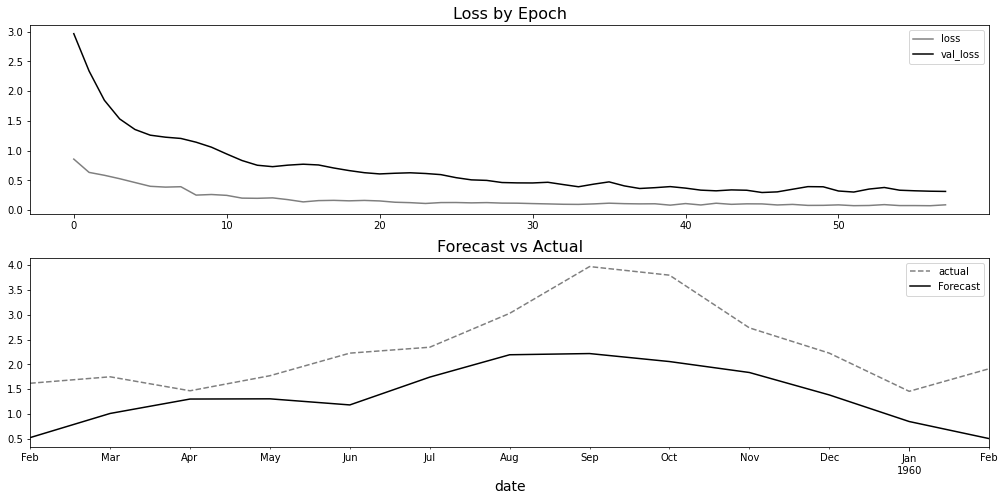

In [38]:
plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

### Avg Daily Temp

In [39]:
tf.keras.backend.clear_session()

In [40]:
model_dw_simpleRNN = create_model(x_train_dw, units=32)

In [41]:
model_dw_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [42]:
history_dw_simpleRNN = train_model_ts(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 2s 12ms/step - loss: 0.5418 - root_mean_squared_error: 0.7361 - mean_absolute_error: 0.5484 - val_loss: 0.3963 - val_root_mean_squared_error: 0.6295 - val_mean_absolute_error: 0.4915
Epoch 2/500
37/37 [==============================] - 0s 6ms/step - loss: 0.4721 - root_mean_squared_error: 0.6871 - mean_absolute_error: 0.5029 - val_loss: 0.3872 - val_root_mean_squared_error: 0.6222 - val_mean_absolute_error: 0.4779
Epoch 3/500
37/37 [==============================] - 0s 8ms/step - loss: 0.4423 - root_mean_squared_error: 0.6651 - mean_absolute_error: 0.4801 - val_loss: 0.3823 - val_root_mean_squared_error: 0.6183 - val_mean_absolute_error: 0.4700
Epoch 4/500
37/37 [==============================] - 0s 8ms/step - loss: 0.4484 - root_mean_squared_error: 0.6696 - mean_absolute_error: 0.4777 - val_loss: 0.3796 - val_root_mean_squared_error: 0.6161 - val_mean_absolute_error: 0.4680
Epoch 5/500
37/37 [==============================] - 0s 7ms

In [43]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

10/10 [==============================] - 0s 8ms/step - loss: 0.3483 - root_mean_squared_error: 0.5902 - mean_absolute_error: 0.4225


[0.34834909439086914, 0.590211033821106, 0.4224809408187866]

10/10 [==============================] - 0s 2ms/step


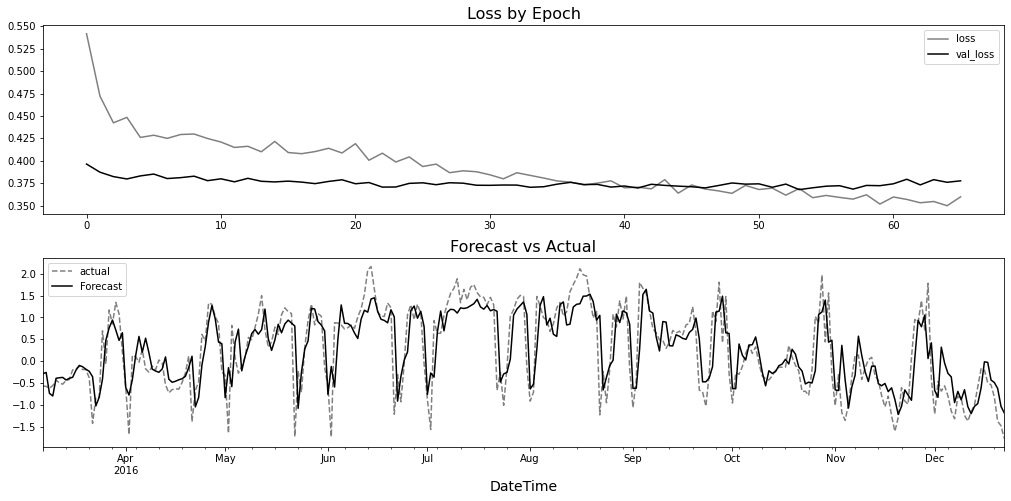

In [44]:
plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

### Energy Consumption

In [45]:
tf.keras.backend.clear_session()

In [46]:
model_en_simpleRNN = create_model(x_train_en, units=32)
model_en_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [47]:
history_en_simpleRNN = train_model_ts(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 1s 56ms/step - loss: 1.6686 - root_mean_squared_error: 1.2918 - mean_absolute_error: 1.0716 - val_loss: 1.7676 - val_root_mean_squared_error: 1.3295 - val_mean_absolute_error: 1.0194
Epoch 2/500
8/8 [==============================] - 0s 12ms/step - loss: 1.1365 - root_mean_squared_error: 1.0661 - mean_absolute_error: 0.8875 - val_loss: 1.2787 - val_root_mean_squared_error: 1.1308 - val_mean_absolute_error: 0.8877
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 0.8376 - root_mean_squared_error: 0.9152 - mean_absolute_error: 0.7574 - val_loss: 0.8900 - val_root_mean_squared_error: 0.9434 - val_mean_absolute_error: 0.7416
Epoch 4/500
8/8 [==============================] - 0s 17ms/step - loss: 0.5975 - root_mean_squared_error: 0.7730 - mean_absolute_error: 0.6247 - val_loss: 0.6080 - val_root_mean_squared_error: 0.7798 - val_mean_absolute_error: 0.6094
Epoch 5/500
8/8 [==============================] - 0s 12ms/step 

In [48]:
model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

2/2 [==============================] - 0s 5ms/step - loss: 0.1032 - root_mean_squared_error: 0.3212 - mean_absolute_error: 0.2529


[0.10317610204219818, 0.3212103843688965, 0.25288230180740356]

In [49]:
y_test_air.shape

(13, 1)

2/2 [==============================] - 0s 3ms/step


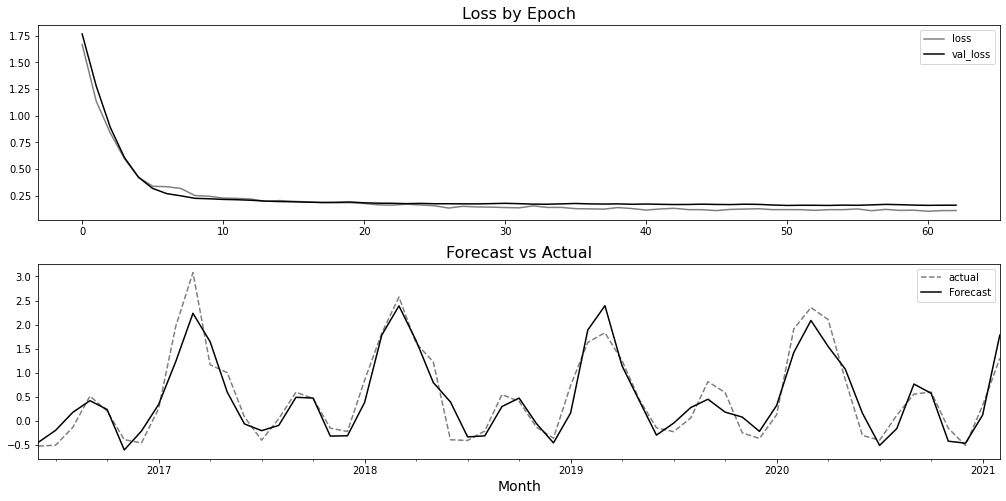

In [50]:
plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

In [51]:
scale_en.inverse_y(y_test_en[0:5])

array([[1309.744],
       [1316.979],
       [1463.766],
       [1721.174],
       [1598.033]])

In [52]:
scale_en.inverse_y(model_en_simpleRNN.predict(x_test_en)[0:5])

2/2 [==============================] - 0s 3ms/step


array([[1341.4238],
       [1439.4296],
       [1587.4615],
       [1683.472 ],
       [1611.5323]], dtype=float32)

In [53]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(keras.layers.Lin)
    
    return model

## LSTM

In [54]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [55]:
tf.keras.backend.clear_session()

In [56]:
model_a_lstm = create_model(train=x_train_air, units=32)
model_a_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [57]:
history_a_lstm = train_model_ts(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 4s 242ms/step - loss: 0.7797 - root_mean_squared_error: 0.8830 - mean_absolute_error: 0.7247 - val_loss: 2.9680 - val_root_mean_squared_error: 1.7228 - val_mean_absolute_error: 1.5318
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6509 - root_mean_squared_error: 0.8068 - mean_absolute_error: 0.6372 - val_loss: 2.4679 - val_root_mean_squared_error: 1.5710 - val_mean_absolute_error: 1.3563
Epoch 3/500
4/4 [==============================] - 0s 17ms/step - loss: 0.5620 - root_mean_squared_error: 0.7497 - mean_absolute_error: 0.5837 - val_loss: 2.0179 - val_root_mean_squared_error: 1.4205 - val_mean_absolute_error: 1.1760
Epoch 4/500
4/4 [==============================] - 0s 36ms/step - loss: 0.4575 - root_mean_squared_error: 0.6764 - mean_absolute_error: 0.5195 - val_loss: 1.6305 - val_root_mean_squared_error: 1.2769 - val_mean_absolute_error: 0.9947
Epoch 5/500
4/4 [==============================] - 0s 17ms/step

In [58]:
model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 32ms/step - loss: 1.2784 - root_mean_squared_error: 1.1307 - mean_absolute_error: 0.8322


[1.2783870697021484, 1.1306577920913696, 0.8322195410728455]

1/1 [==============================] - 1s 570ms/step


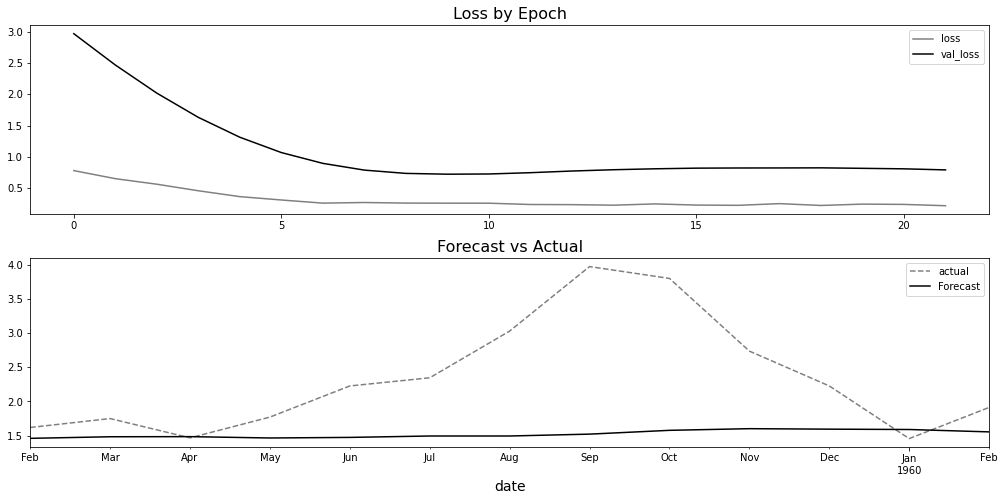

In [59]:
plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

### Avg Daily Temp

In [60]:
tf.keras.backend.clear_session()

In [61]:
model_dw_lstm = create_model(train=x_train_dw, units=32)
model_dw_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [62]:
history_dw_lstm = train_model_ts(model_dw_lstm, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 3s 27ms/step - loss: 0.8637 - root_mean_squared_error: 0.9293 - mean_absolute_error: 0.7498 - val_loss: 0.6873 - val_root_mean_squared_error: 0.8290 - val_mean_absolute_error: 0.6777
Epoch 2/500
37/37 [==============================] - 0s 10ms/step - loss: 0.7398 - root_mean_squared_error: 0.8601 - mean_absolute_error: 0.6694 - val_loss: 0.6111 - val_root_mean_squared_error: 0.7817 - val_mean_absolute_error: 0.6317
Epoch 3/500
37/37 [==============================] - 0s 11ms/step - loss: 0.6814 - root_mean_squared_error: 0.8254 - mean_absolute_error: 0.6372 - val_loss: 0.5531 - val_root_mean_squared_error: 0.7437 - val_mean_absolute_error: 0.5966
Epoch 4/500
37/37 [==============================] - 0s 11ms/step - loss: 0.6292 - root_mean_squared_error: 0.7932 - mean_absolute_error: 0.6023 - val_loss: 0.5048 - val_root_mean_squared_error: 0.7105 - val_mean_absolute_error: 0.5676
Epoch 5/500
37/37 [==============================] - 1s 

10/10 [==============================] - 1s 2ms/step


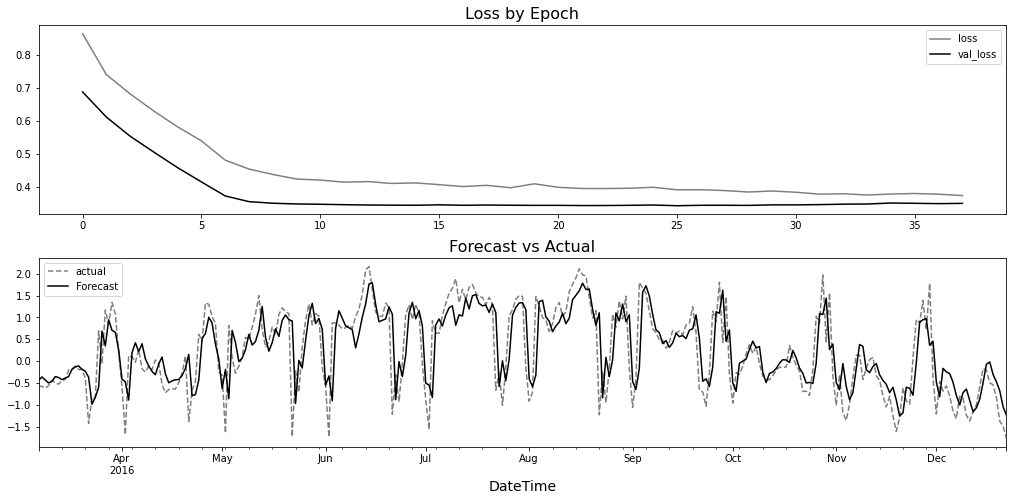

In [63]:
plot_forecast(model_dw_lstm, x_test_dw, y_test_dw, test_dw.index, history_dw_lstm)

### Energy Consumption

In [64]:
tf.keras.backend.clear_session()

In [65]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [66]:
history_en_lstm = train_model_ts(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 4s 112ms/step - loss: 1.0863 - root_mean_squared_error: 1.0423 - mean_absolute_error: 0.8387 - val_loss: 1.4535 - val_root_mean_squared_error: 1.2056 - val_mean_absolute_error: 0.8626
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 1.0306 - root_mean_squared_error: 1.0152 - mean_absolute_error: 0.8223 - val_loss: 1.3943 - val_root_mean_squared_error: 1.1808 - val_mean_absolute_error: 0.8561
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 0.9926 - root_mean_squared_error: 0.9963 - mean_absolute_error: 0.8121 - val_loss: 1.3422 - val_root_mean_squared_error: 1.1585 - val_mean_absolute_error: 0.8515
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 0.9672 - root_mean_squared_error: 0.9835 - mean_absolute_error: 0.8076 - val_loss: 1.2985 - val_root_mean_squared_error: 1.1395 - val_mean_absolute_error: 0.8458
Epoch 5/500
8/8 [==============================] - 0s 16ms/step

2/2 [==============================] - 1s 3ms/step


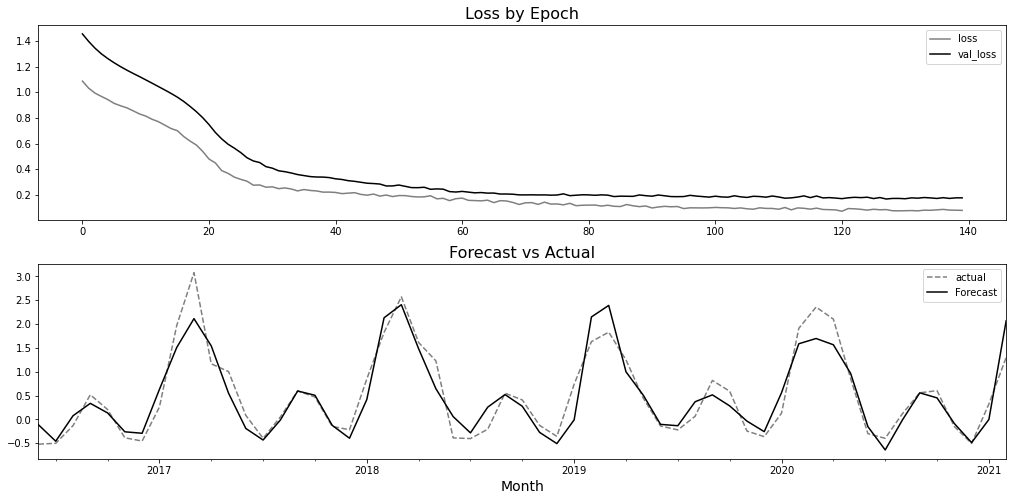

In [67]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## GRU

In [68]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,
                  input_shape=(train.shape[1], 
                               train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [69]:
tf.keras.backend.clear_session()

In [70]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model_ts(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)


Epoch 1/500
4/4 [==============================] - 4s 211ms/step - loss: 0.6563 - root_mean_squared_error: 0.8101 - mean_absolute_error: 0.6592 - val_loss: 2.3827 - val_root_mean_squared_error: 1.5436 - val_mean_absolute_error: 1.3829
Epoch 2/500
4/4 [==============================] - 0s 22ms/step - loss: 0.5729 - root_mean_squared_error: 0.7569 - mean_absolute_error: 0.6114 - val_loss: 2.0239 - val_root_mean_squared_error: 1.4226 - val_mean_absolute_error: 1.2499
Epoch 3/500
4/4 [==============================] - 0s 24ms/step - loss: 0.4437 - root_mean_squared_error: 0.6661 - mean_absolute_error: 0.5349 - val_loss: 1.6969 - val_root_mean_squared_error: 1.3026 - val_mean_absolute_error: 1.1144
Epoch 4/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4051 - root_mean_squared_error: 0.6365 - mean_absolute_error: 0.5054 - val_loss: 1.4095 - val_root_mean_squared_error: 1.1872 - val_mean_absolute_error: 0.9794
Epoch 5/500
4/4 [==============================] - 0s 20ms/step

1/1 [==============================] - 1s 586ms/step


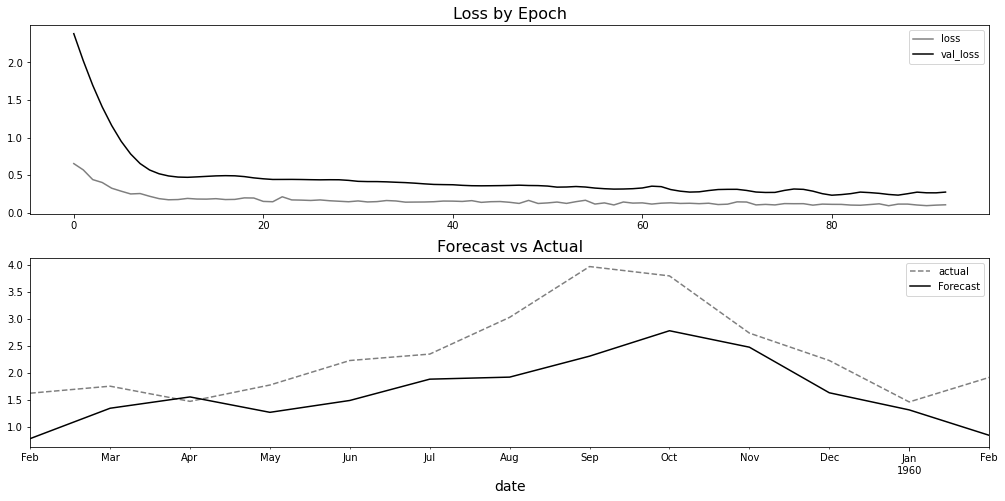

In [71]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

### Avg Daily Temp

In [72]:
tf.keras.backend.clear_session()

In [73]:
model_dw_gru = create_model(train=x_train_dw, units=32)
history_dw_gru = train_model_ts(model_dw_gru, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 4s 29ms/step - loss: 0.8001 - root_mean_squared_error: 0.8945 - mean_absolute_error: 0.7121 - val_loss: 0.5502 - val_root_mean_squared_error: 0.7418 - val_mean_absolute_error: 0.5877
Epoch 2/500
37/37 [==============================] - 0s 11ms/step - loss: 0.6240 - root_mean_squared_error: 0.7899 - mean_absolute_error: 0.5963 - val_loss: 0.4712 - val_root_mean_squared_error: 0.6865 - val_mean_absolute_error: 0.5429
Epoch 3/500
37/37 [==============================] - 0s 11ms/step - loss: 0.5535 - root_mean_squared_error: 0.7440 - mean_absolute_error: 0.5561 - val_loss: 0.4233 - val_root_mean_squared_error: 0.6506 - val_mean_absolute_error: 0.5124
Epoch 4/500
37/37 [==============================] - 0s 9ms/step - loss: 0.5053 - root_mean_squared_error: 0.7108 - mean_absolute_error: 0.5250 - val_loss: 0.3935 - val_root_mean_squared_error: 0.6273 - val_mean_absolute_error: 0.4907
Epoch 5/500
37/37 [==============================] - 0s 1

10/10 [==============================] - 1s 6ms/step


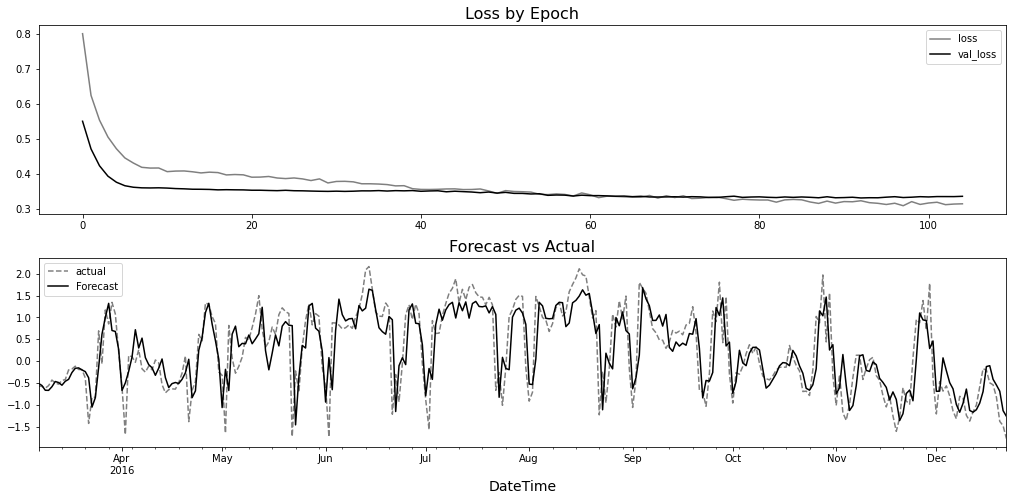

In [74]:
plot_forecast(model_dw_gru, x_test_dw, y_test_dw, test_dw.index, history_dw_gru)

### Energy Consumption

In [75]:
tf.keras.backend.clear_session()

In [76]:
model_en_gru = create_model(x_train_en, units=32)
model_en_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [77]:
history_en_gru = train_model_ts(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 3s 95ms/step - loss: 0.7766 - root_mean_squared_error: 0.8812 - mean_absolute_error: 0.7141 - val_loss: 1.0558 - val_root_mean_squared_error: 1.0275 - val_mean_absolute_error: 0.7760
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 0.7078 - root_mean_squared_error: 0.8413 - mean_absolute_error: 0.6778 - val_loss: 0.9868 - val_root_mean_squared_error: 0.9934 - val_mean_absolute_error: 0.7555
Epoch 3/500
8/8 [==============================] - 0s 21ms/step - loss: 0.6539 - root_mean_squared_error: 0.8086 - mean_absolute_error: 0.6460 - val_loss: 0.9214 - val_root_mean_squared_error: 0.9599 - val_mean_absolute_error: 0.7371
Epoch 4/500
8/8 [==============================] - 0s 24ms/step - loss: 0.6059 - root_mean_squared_error: 0.7784 - mean_absolute_error: 0.6259 - val_loss: 0.8639 - val_root_mean_squared_error: 0.9295 - val_mean_absolute_error: 0.7182
Epoch 5/500
8/8 [==============================] - 0s 16ms/step 

2/2 [==============================] - 1s 4ms/step


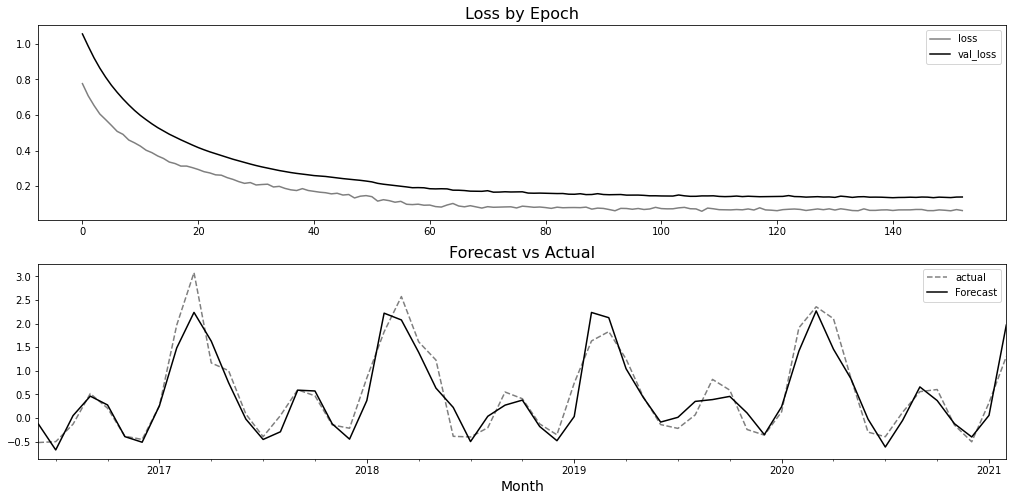

In [78]:
plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Deep RNN-LSTM

### Air Passenger

In [79]:
tf.keras.backend.clear_session()

In [80]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [81]:
model_a_deep = create_model(train=x_train_air, units=32)
history_a_deep = train_model_ts(model_a_deep, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 6s 419ms/step - loss: 1.1111 - root_mean_squared_error: 1.0541 - mean_absolute_error: 0.8829 - val_loss: 3.9950 - val_root_mean_squared_error: 1.9988 - val_mean_absolute_error: 1.8433
Epoch 2/500
4/4 [==============================] - 0s 26ms/step - loss: 0.9230 - root_mean_squared_error: 0.9607 - mean_absolute_error: 0.7908 - val_loss: 3.4227 - val_root_mean_squared_error: 1.8501 - val_mean_absolute_error: 1.6764
Epoch 3/500
4/4 [==============================] - 0s 31ms/step - loss: 0.7878 - root_mean_squared_error: 0.8876 - mean_absolute_error: 0.7228 - val_loss: 2.9166 - val_root_mean_squared_error: 1.7078 - val_mean_absolute_error: 1.5132
Epoch 4/500
4/4 [==============================] - 0s 30ms/step - loss: 0.6678 - root_mean_squared_error: 0.8172 - mean_absolute_error: 0.6528 - val_loss: 2.4551 - val_root_mean_squared_error: 1.5669 - val_mean_absolute_error: 1.3469
Epoch 5/500
4/4 [==============================] - 0s 30ms/step

In [82]:
model_a_deep.evaluate(x_test_air, y_test_air)

1/1 [==============================] - 0s 43ms/step - loss: 1.4487 - root_mean_squared_error: 1.2036 - mean_absolute_error: 0.8876


[1.448701024055481, 1.2036199569702148, 0.8875523209571838]

1/1 [==============================] - 1s 1s/step


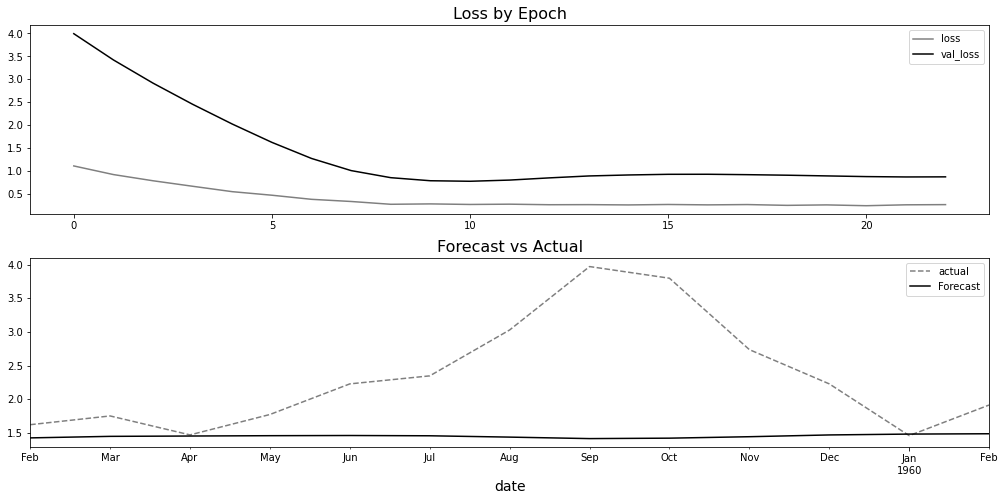

In [83]:
plot_forecast(model_a_deep, x_test_air, y_test_air, test_air.index, history_a_deep)

### Avg Daily Temp

In [84]:
tf.keras.backend.clear_session()

Epoch 1/500
37/37 [==============================] - 7s 47ms/step - loss: 0.8549 - root_mean_squared_error: 0.9246 - mean_absolute_error: 0.7355 - val_loss: 0.7064 - val_root_mean_squared_error: 0.8405 - val_mean_absolute_error: 0.6783
Epoch 2/500
37/37 [==============================] - 1s 19ms/step - loss: 0.7943 - root_mean_squared_error: 0.8913 - mean_absolute_error: 0.6972 - val_loss: 0.6532 - val_root_mean_squared_error: 0.8082 - val_mean_absolute_error: 0.6499
Epoch 3/500
37/37 [==============================] - 1s 17ms/step - loss: 0.7347 - root_mean_squared_error: 0.8572 - mean_absolute_error: 0.6646 - val_loss: 0.5926 - val_root_mean_squared_error: 0.7698 - val_mean_absolute_error: 0.6169
Epoch 4/500
37/37 [==============================] - 1s 18ms/step - loss: 0.6636 - root_mean_squared_error: 0.8146 - mean_absolute_error: 0.6269 - val_loss: 0.5105 - val_root_mean_squared_error: 0.7145 - val_mean_absolute_error: 0.5683
Epoch 5/500
37/37 [==============================] - 1s 

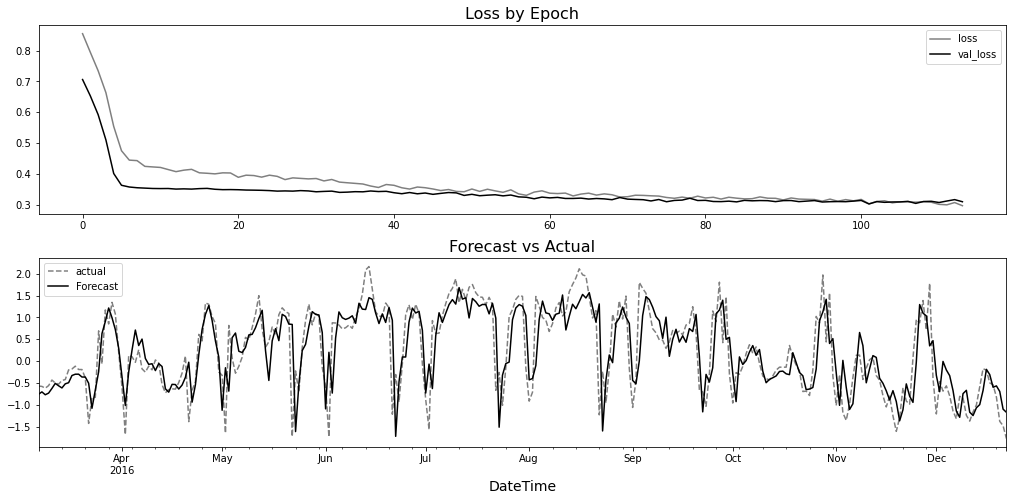

In [85]:
model_dw_deep = create_model(x_train_dw, units=32)
history_dw_deep = train_model_ts(model_dw_deep, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_deep, x_test_dw, y_test_dw, test_dw.index, history_dw_deep)

### Energy Consumption

In [86]:
tf.keras.backend.clear_session()

Epoch 1/500
8/8 [==============================] - 6s 235ms/step - loss: 1.0327 - root_mean_squared_error: 1.0162 - mean_absolute_error: 0.8200 - val_loss: 1.4155 - val_root_mean_squared_error: 1.1898 - val_mean_absolute_error: 0.8585
Epoch 2/500
8/8 [==============================] - 0s 22ms/step - loss: 0.9966 - root_mean_squared_error: 0.9983 - mean_absolute_error: 0.8114 - val_loss: 1.3842 - val_root_mean_squared_error: 1.1765 - val_mean_absolute_error: 0.8603
Epoch 3/500
8/8 [==============================] - 0s 24ms/step - loss: 0.9822 - root_mean_squared_error: 0.9911 - mean_absolute_error: 0.8105 - val_loss: 1.3562 - val_root_mean_squared_error: 1.1646 - val_mean_absolute_error: 0.8620
Epoch 4/500
8/8 [==============================] - 0s 22ms/step - loss: 0.9719 - root_mean_squared_error: 0.9858 - mean_absolute_error: 0.8105 - val_loss: 1.3345 - val_root_mean_squared_error: 1.1552 - val_mean_absolute_error: 0.8633
Epoch 5/500
8/8 [==============================] - 0s 29ms/step

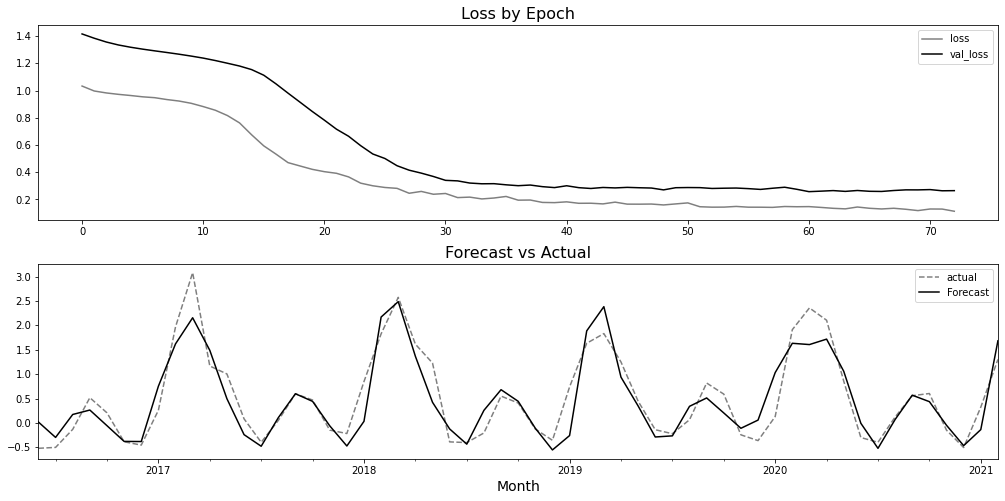

In [87]:
model_en_deep = create_model(x_train_en, units=32)
history_en_deep = train_model_ts(model_en_deep, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_deep, x_test_en, y_test_en, test_en.index, history_en_deep)

## Bidirectional

In [88]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, 
                                 input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [89]:
tf.keras.backend.clear_session()

In [90]:
model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model_ts(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 12s 654ms/step - loss: 0.7828 - root_mean_squared_error: 0.8847 - mean_absolute_error: 0.7221 - val_loss: 2.4310 - val_root_mean_squared_error: 1.5592 - val_mean_absolute_error: 1.3527
Epoch 2/500
4/4 [==============================] - 0s 27ms/step - loss: 0.5099 - root_mean_squared_error: 0.7141 - mean_absolute_error: 0.5620 - val_loss: 1.5774 - val_root_mean_squared_error: 1.2559 - val_mean_absolute_error: 0.9805
Epoch 3/500
4/4 [==============================] - 0s 29ms/step - loss: 0.3406 - root_mean_squared_error: 0.5836 - mean_absolute_error: 0.4489 - val_loss: 0.9684 - val_root_mean_squared_error: 0.9841 - val_mean_absolute_error: 0.7277
Epoch 4/500
4/4 [==============================] - 0s 28ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904 - mean_absolute_error: 0.3825 - val_loss: 0.6865 - val_root_mean_squared_error: 0.8286 - val_mean_absolute_error: 0.6350
Epoch 5/500
4/4 [==============================] - 0s 31ms/ste

In [91]:
model_a_bd.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 37ms/step - loss: 1.2389 - root_mean_squared_error: 1.1130 - mean_absolute_error: 0.8268


[1.2388646602630615, 1.113042950630188, 0.8268107771873474]

1/1 [==============================] - 2s 2s/step


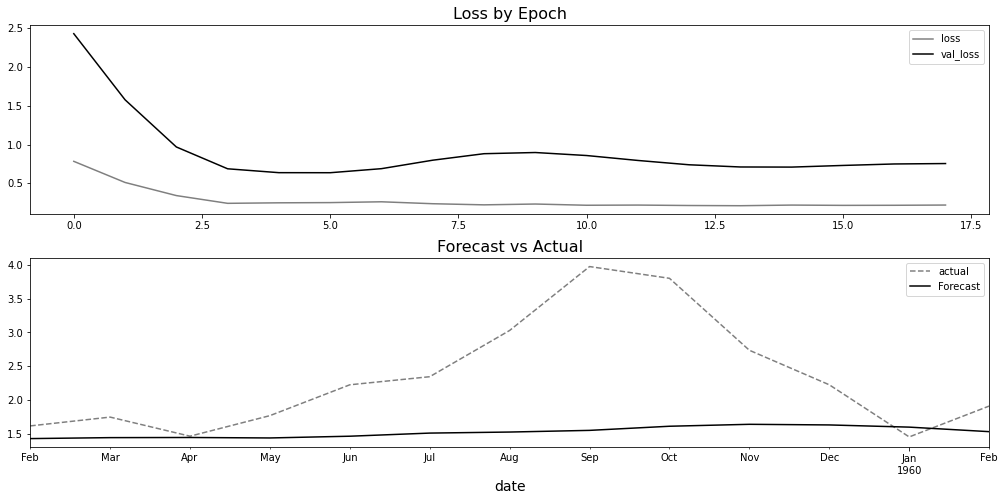

In [92]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [93]:
tf.keras.backend.clear_session()

In [94]:
model_dw_bd = create_model(x_train_dw, units=32)
history_dw_bd = train_model_ts(model_dw_bd, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 12s 79ms/step - loss: 0.8000 - root_mean_squared_error: 0.8944 - mean_absolute_error: 0.7012 - val_loss: 0.5894 - val_root_mean_squared_error: 0.7677 - val_mean_absolute_error: 0.6082
Epoch 2/500
37/37 [==============================] - 1s 22ms/step - loss: 0.6451 - root_mean_squared_error: 0.8032 - mean_absolute_error: 0.6041 - val_loss: 0.4732 - val_root_mean_squared_error: 0.6879 - val_mean_absolute_error: 0.5413
Epoch 3/500
37/37 [==============================] - 1s 20ms/step - loss: 0.5390 - root_mean_squared_error: 0.7342 - mean_absolute_error: 0.5471 - val_loss: 0.3967 - val_root_mean_squared_error: 0.6298 - val_mean_absolute_error: 0.4943
Epoch 4/500
37/37 [==============================] - 1s 24ms/step - loss: 0.4715 - root_mean_squared_error: 0.6866 - mean_absolute_error: 0.4977 - val_loss: 0.3608 - val_root_mean_squared_error: 0.6007 - val_mean_absolute_error: 0.4631
Epoch 5/500
37/37 [==============================] - 1s

In [95]:
x_test_dw.shape

(291, 10, 1)

In [96]:
model_dw_bd.predict(x_test_dw).shape

10/10 [==============================] - 2s 4ms/step


(291, 1)

10/10 [==============================] - 0s 7ms/step


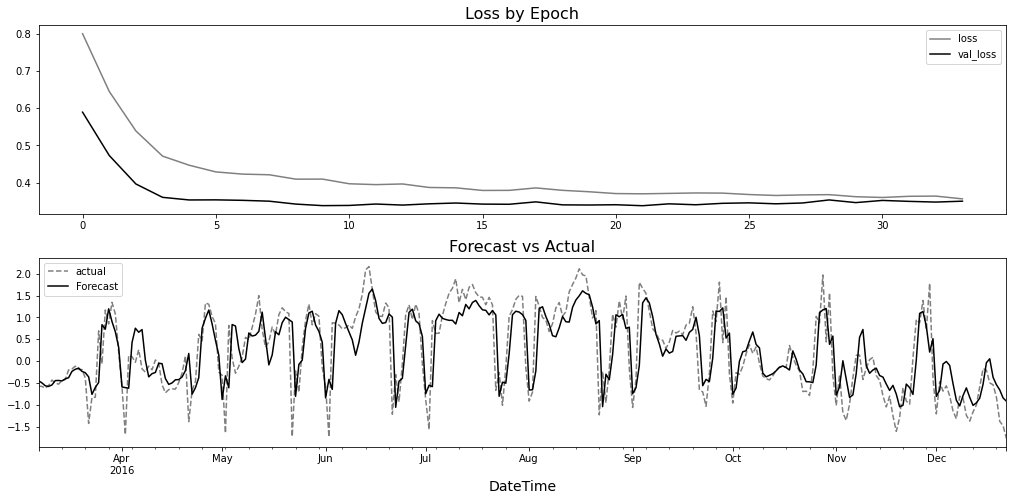

In [97]:
plot_forecast(model_dw_bd, x_test_dw, y_test_dw, test_dw.index, history_dw_bd)

### Energy Consumption

In [98]:
tf.keras.backend.clear_session()

Epoch 1/500
8/8 [==============================] - 11s 285ms/step - loss: 0.9930 - root_mean_squared_error: 0.9965 - mean_absolute_error: 0.8134 - val_loss: 1.3182 - val_root_mean_squared_error: 1.1481 - val_mean_absolute_error: 0.8530
Epoch 2/500
8/8 [==============================] - 0s 30ms/step - loss: 0.9266 - root_mean_squared_error: 0.9626 - mean_absolute_error: 0.7925 - val_loss: 1.2503 - val_root_mean_squared_error: 1.1182 - val_mean_absolute_error: 0.8489
Epoch 3/500
8/8 [==============================] - 0s 31ms/step - loss: 0.8893 - root_mean_squared_error: 0.9430 - mean_absolute_error: 0.7779 - val_loss: 1.1990 - val_root_mean_squared_error: 1.0950 - val_mean_absolute_error: 0.8411
Epoch 4/500
8/8 [==============================] - 0s 25ms/step - loss: 0.8432 - root_mean_squared_error: 0.9183 - mean_absolute_error: 0.7571 - val_loss: 1.1565 - val_root_mean_squared_error: 1.0754 - val_mean_absolute_error: 0.8292
Epoch 5/500
8/8 [==============================] - 0s 32ms/ste

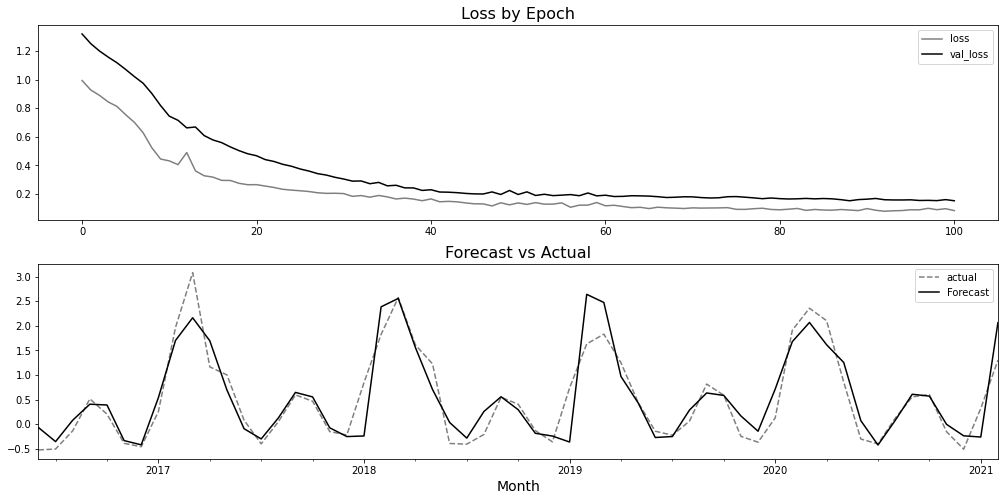

In [99]:
model_en_bd = create_model(x_train_en, units=32)
history_en_bd = train_model_ts(model_en_bd, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_bd, x_test_en, y_test_en, test_en.index, history_en_bd)

## Timedistributed

In [100]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model

### Air Passenger

In [101]:
tf.keras.backend.clear_session()

In [102]:
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model_ts(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 6s 381ms/step - loss: 1.0159 - root_mean_squared_error: 1.0079 - mean_absolute_error: 0.8392 - val_loss: 3.8424 - val_root_mean_squared_error: 1.9602 - val_mean_absolute_error: 1.8012
Epoch 2/500
4/4 [==============================] - 0s 26ms/step - loss: 0.9182 - root_mean_squared_error: 0.9582 - mean_absolute_error: 0.7915 - val_loss: 3.5151 - val_root_mean_squared_error: 1.8749 - val_mean_absolute_error: 1.7035
Epoch 3/500
4/4 [==============================] - 0s 28ms/step - loss: 0.8374 - root_mean_squared_error: 0.9151 - mean_absolute_error: 0.7489 - val_loss: 3.1944 - val_root_mean_squared_error: 1.7873 - val_mean_absolute_error: 1.5994
Epoch 4/500
4/4 [==============================] - 0s 34ms/step - loss: 0.7614 - root_mean_squared_error: 0.8726 - mean_absolute_error: 0.7055 - val_loss: 2.8779 - val_root_mean_squared_error: 1.6964 - val_mean_absolute_error: 1.4860
Epoch 5/500
4/4 [==============================] - 0s 38ms/step

In [103]:
model_a_td.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 40ms/step - loss: 2.5668 - root_mean_squared_error: 1.6021 - mean_absolute_error: 1.4253


[2.5667741298675537, 1.602115511894226, 1.4252636432647705]

1/1 [==============================] - 1s 656ms/step


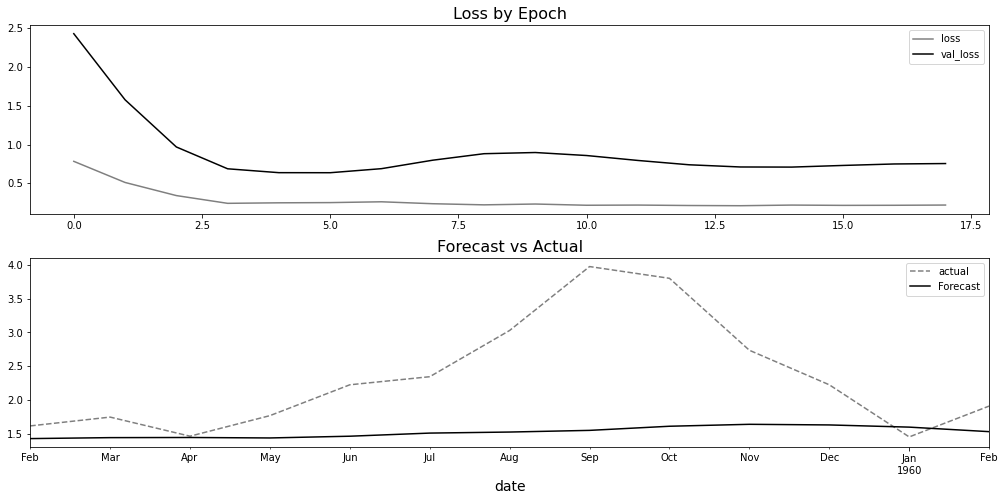

In [104]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [105]:
tf.keras.backend.clear_session()

In [106]:
model_dw_td = create_model(x_train_dw, units=32)
history_dw_td = train_model_ts(model_dw_td, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 8s 45ms/step - loss: 0.9509 - root_mean_squared_error: 0.9751 - mean_absolute_error: 0.7976 - val_loss: 0.8327 - val_root_mean_squared_error: 0.9125 - val_mean_absolute_error: 0.7498
Epoch 2/500
37/37 [==============================] - 1s 17ms/step - loss: 0.9170 - root_mean_squared_error: 0.9576 - mean_absolute_error: 0.7705 - val_loss: 0.8190 - val_root_mean_squared_error: 0.9050 - val_mean_absolute_error: 0.7438
Epoch 3/500
37/37 [==============================] - 1s 22ms/step - loss: 0.9105 - root_mean_squared_error: 0.9542 - mean_absolute_error: 0.7669 - val_loss: 0.8143 - val_root_mean_squared_error: 0.9024 - val_mean_absolute_error: 0.7412
Epoch 4/500
37/37 [==============================] - 1s 18ms/step - loss: 0.9052 - root_mean_squared_error: 0.9514 - mean_absolute_error: 0.7635 - val_loss: 0.8098 - val_root_mean_squared_error: 0.8999 - val_mean_absolute_error: 0.7390
Epoch 5/500
37/37 [==============================] - 1s 

### Energy Consumption

In [107]:
tf.keras.backend.clear_session()

In [108]:
model_en_td = create_model(x_train_en, units=32)
history_en_td = train_model_ts(model_en_td, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 7s 224ms/step - loss: 1.0078 - root_mean_squared_error: 1.0039 - mean_absolute_error: 0.8213 - val_loss: 1.3822 - val_root_mean_squared_error: 1.1757 - val_mean_absolute_error: 0.8629
Epoch 2/500
8/8 [==============================] - 0s 28ms/step - loss: 0.9964 - root_mean_squared_error: 0.9982 - mean_absolute_error: 0.8159 - val_loss: 1.3797 - val_root_mean_squared_error: 1.1746 - val_mean_absolute_error: 0.8626
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 0.9939 - root_mean_squared_error: 0.9970 - mean_absolute_error: 0.8156 - val_loss: 1.3735 - val_root_mean_squared_error: 1.1720 - val_mean_absolute_error: 0.8623
Epoch 4/500
8/8 [==============================] - 0s 20ms/step - loss: 0.9924 - root_mean_squared_error: 0.9962 - mean_absolute_error: 0.8161 - val_loss: 1.3669 - val_root_mean_squared_error: 1.1692 - val_mean_absolute_error: 0.8621
Epoch 5/500
8/8 [==============================] - 0s 22ms/step

## Compare

In [110]:
scores = pd.DataFrame(np.array(
    [model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_a_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_a_gru.evaluate(x=x_test_air, y=y_test_air),
    model_a_deep.evaluate(x=x_test_air, y=y_test_air),
    model_a_bd.evaluate(x=x_test_air, y=y_test_air),
    model_a_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM', 'Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 349ms/step - loss: 2.5668 - root_mean_squared_error: 1.6021 - mean_absolute_error: 1.4253


,MSE,RMSE,MAE
GRU,0.659205,0.811914,0.687278
SimpleRNN,1.087949,1.043048,0.939369
Bidirectional,1.238865,1.113043,0.826811
LSTM,1.278387,1.130658,0.832220
Deep LSTM,1.448701,1.203620,0.887552
TimeDistributed,2.566774,1.602116,1.425264


In [111]:
scores = pd.DataFrame(np.array(
    [model_dw_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_dw_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_dw_gru.evaluate(x=x_test_air, y=y_test_air),
    model_dw_deep.evaluate(x=x_test_air, y=y_test_air),
    model_dw_bd.evaluate(x=x_test_air, y=y_test_air),
    model_dw_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 1s 549ms/step - loss: 2.0739 - root_mean_squared_error: 1.4401 - mean_absolute_error: 1.1323


,MSE,RMSE,MAE
LSTM,0.436292,0.660524,0.545735
Deep LSTM,0.672525,0.820076,0.583027
SimpleRNN,0.702289,0.838027,0.683084
GRU,0.705141,0.839727,0.745048
Bidirectional,0.936082,0.967513,0.803917
TimeDistributed,2.073873,1.440095,1.132277


In [112]:
scores = pd.DataFrame(np.array(
    [model_en_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_en_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_en_gru.evaluate(x=x_test_air, y=y_test_air),
    model_en_deep.evaluate(x=x_test_air, y=y_test_air),
    model_en_bd.evaluate(x=x_test_air, y=y_test_air),
    model_en_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 28ms/step - loss: 6.5725 - root_mean_squared_error: 2.5637 - mean_absolute_error: 2.4050


,MSE,RMSE,MAE
SimpleRNN,1.075563,1.037093,0.887493
GRU,1.961736,1.400620,1.299179
LSTM,2.234528,1.494834,1.292848
Deep LSTM,3.433442,1.852955,1.720845
Bidirectional,5.354222,2.313919,2.197775
TimeDistributed,6.572453,2.563680,2.405035


## How it works

In [115]:
patience=12
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)

In [116]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential(
        [SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])),
         Dropout(dropout),
         Dense(1)
        ]
    )
    
    return model

In [117]:
tf.keras.backend.clear_session()
model_a_simpleRNN_1 = create_model(train=x_train_air, units=32)
model_a_simpleRNN_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [118]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

tf.keras.backend.clear_session()
model_a_simpleRNN = create_model(train=x_train_air, units=32)
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


## There is more

Using Keras Model API 

In [119]:
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.metrics import (RootMeanSquaredError, 
                                     MeanAbsoluteError)
from keras.layers import (Dense,  
                LSTM, Dropout, 
                Input, Activation)

In [120]:
from tensorflow.keras import Model
from keras.layers import (Dense,  
                SimpleRNN, Dropout, 
                Input)

def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(10,1))
    rnn = SimpleRNN(units, return_sequences=True)(input_data)
    dropout = Dropout(dropout)(rnn)
    output = Dense(1)(dropout)
    model = Model(inputs=input_data, outputs=output)
    return model

In [121]:
from tensorflow.keras import Model
from keras.layers import (Dense,  
                SimpleRNN, Dropout, 
                Input)

def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(10,1))
    lstm_1 = LSTM(units, return_sequences=True)(input_data)
    dropout_1 = Dropout(dropout)(lstm_1)
    lstm_2 = LSTM(units)(dropout_1)
    dropout_2 = Dropout(dropout)(lstm_2)
    output = Dense(1)(dropout_2)
    model = Model(inputs=input_data, outputs=output)
    
    return model

model_en_deep_lstm = create_model(train=x_train_en, units=32)
model_en_deep_lstm.summary()
history_en_deep_lstm = train_model_ts(model_en_deep_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 dropout_1 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable p

2/2 [==============================] - 0s 5ms/step


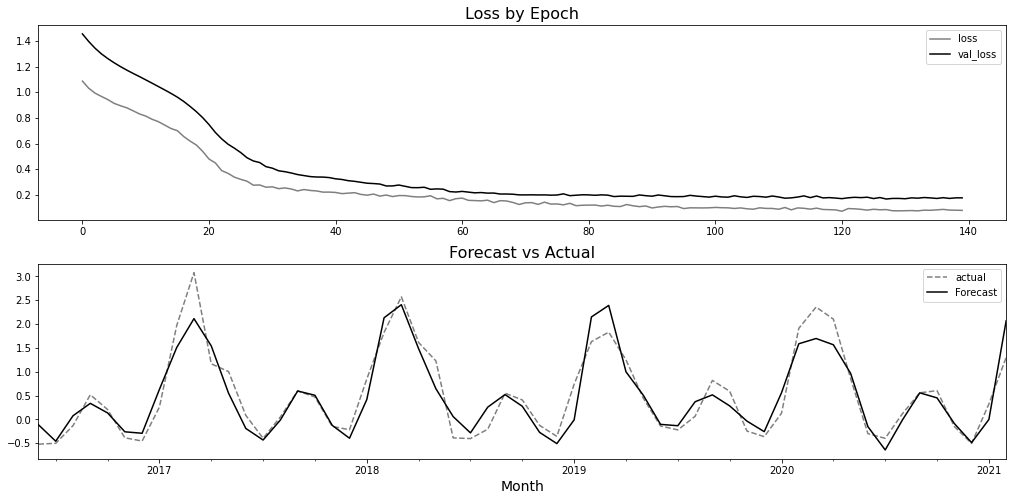

In [122]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

In [123]:
tf.keras.backend.clear_session()

In [124]:
model_a_m = create_model(train=x_train_air, units=32)
model_a_m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable p

### Air Passenger

In [125]:
history_a_m = train_model_ts(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 8s 525ms/step - loss: 0.9370 - root_mean_squared_error: 0.9680 - mean_absolute_error: 0.7983 - val_loss: 3.3586 - val_root_mean_squared_error: 1.8326 - val_mean_absolute_error: 1.6573
Epoch 2/500
4/4 [==============================] - 0s 47ms/step - loss: 0.7526 - root_mean_squared_error: 0.8675 - mean_absolute_error: 0.7049 - val_loss: 2.7914 - val_root_mean_squared_error: 1.6708 - val_mean_absolute_error: 1.4718
Epoch 3/500
4/4 [==============================] - 0s 33ms/step - loss: 0.6255 - root_mean_squared_error: 0.7909 - mean_absolute_error: 0.6247 - val_loss: 2.2425 - val_root_mean_squared_error: 1.4975 - val_mean_absolute_error: 1.2665
Epoch 4/500
4/4 [==============================] - 0s 41ms/step - loss: 0.4964 - root_mean_squared_error: 0.7046 - mean_absolute_error: 0.5520 - val_loss: 1.7259 - val_root_mean_squared_error: 1.3137 - val_mean_absolute_error: 1.0364
Epoch 5/500
4/4 [==============================] - 0s 58ms/step

In [126]:
model_a_m.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 35ms/step - loss: 1.4358 - root_mean_squared_error: 1.1983 - mean_absolute_error: 0.8884


[1.4358079433441162, 1.1982520818710327, 0.8884435296058655]

1/1 [==============================] - 1s 1s/step


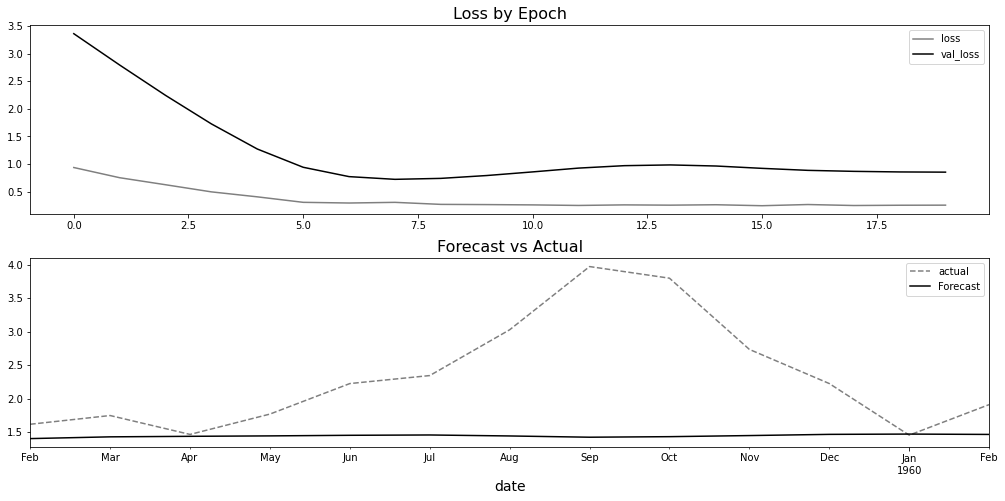

In [127]:
plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index, history_a_m)